In [1]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mb_size = 64

#transform data to tensor 
transform = transforms.ToTensor()

#train=True will only download traning dataset
traindata = torchvision.datasets.MNIST('./NewData/', download=True, transform=transform, train = True)

# Loading the training data
trainloader = torch.utils.data.DataLoader(traindata, shuffle=True, batch_size=mb_size)

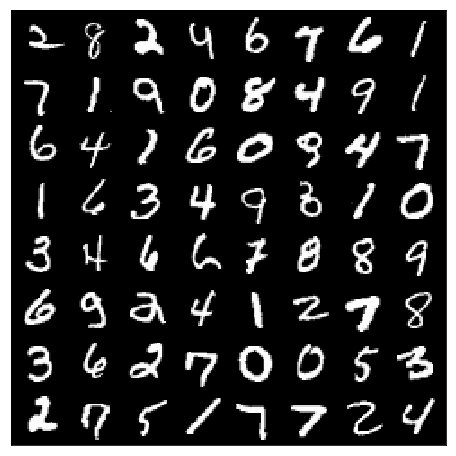

In [4]:
#iterator 
dataIter = iter(trainloader)
imgs, labels = dataIter.next()


# Visualize a grid of imgs
def imshow(imgs):
    # make_grid will make a grid out of images
    imgs = torchvision.utils.make_grid(imgs)
    # transfoming tensors back to numpy 
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

imshow(imgs)


In [5]:
Z_dim = 100    # dimension of the input noise for generator
H_dim = 128    # number of hidden neurons in our hidden layer
lr = 1e-3      # learning rate
X_dim = imgs.view(imgs.size(0), -1).size(1) #image size

In [6]:
def xavier_init(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [7]:
# Generator
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, X_dim),
            nn.Sigmoid()
        )
        self.model.apply(xavier_init)
    
    def forward(self, input):
        return self.model(input)

In [8]:
# Discriminator
class Dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, H_dim),
            nn.ReLU(),
            nn.Linear(H_dim, 1),
            nn.Sigmoid()
        )
        self.model.apply(xavier_init)
    
    def forward(self, input):
        return self.model(input)

In [9]:
# Instantiating the networks
G = Gen()
D = Dis()
print(G)
print(D)

Gen(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Dis(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [10]:
# Defining solver - Adam
# one for each network 
G_solver = opt.Adam(G.parameters(), lr = lr)
D_solver = opt.Adam(D.parameters(), lr = lr)

Epoch:0,   G_loss:6.3386287987867656,   D_loss:0.06263056967302219


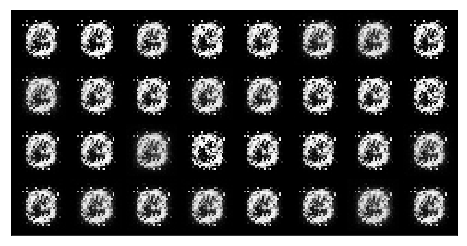

Epoch:1,   G_loss:5.247581844390837,   D_loss:0.06844691458299185


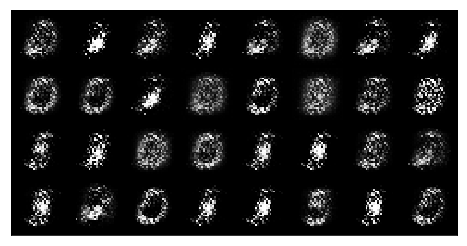

Epoch:2,   G_loss:4.489189371879675,   D_loss:0.13762879961811658


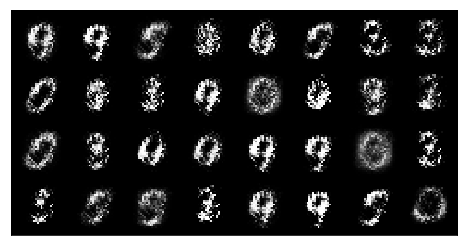

Epoch:3,   G_loss:4.789806236844582,   D_loss:0.24505620110613197


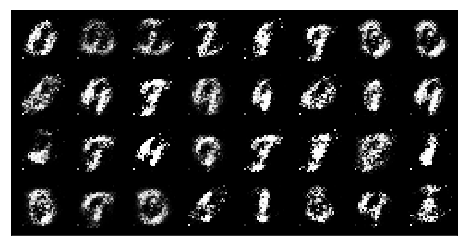

Epoch:4,   G_loss:4.60430133647756,   D_loss:0.2987487152901921


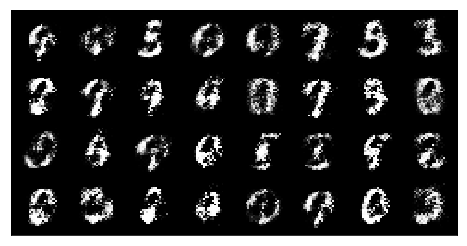

Epoch:5,   G_loss:4.392102031311246,   D_loss:0.3254886681813675


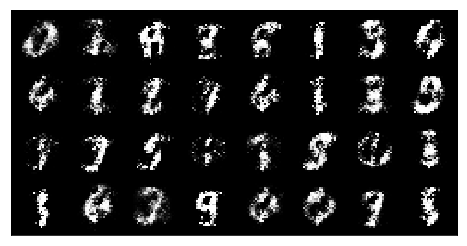

Epoch:6,   G_loss:3.8168356649911224,   D_loss:0.4223330901629889


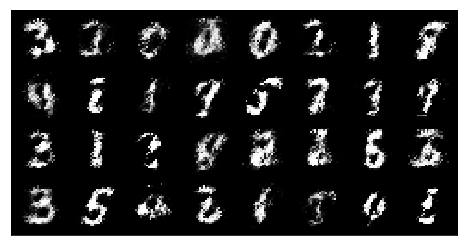

Epoch:7,   G_loss:3.463255283420782,   D_loss:0.5150583405802245


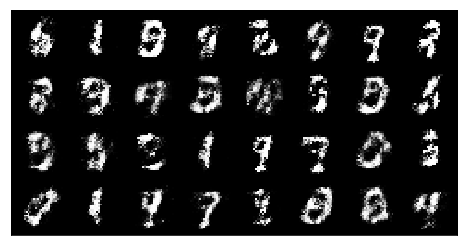

Epoch:8,   G_loss:3.272909769117197,   D_loss:0.5800816888080985


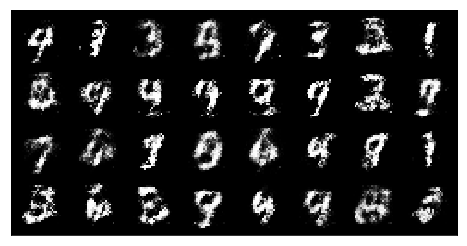

Epoch:9,   G_loss:2.724720787264899,   D_loss:0.6552329038315491


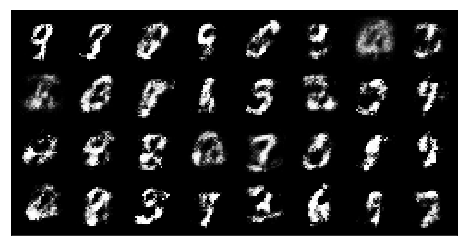

Epoch:10,   G_loss:2.4838954184863615,   D_loss:0.7217254623738941


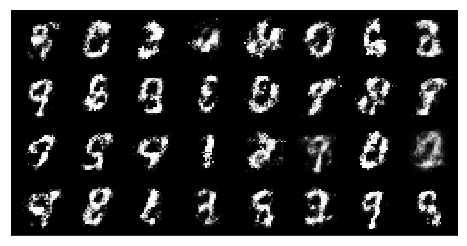

Epoch:11,   G_loss:2.4121057539860575,   D_loss:0.717436592112472


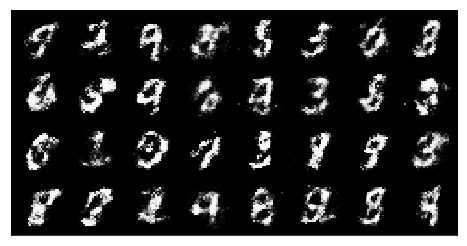

Epoch:12,   G_loss:2.175301534280594,   D_loss:0.7796958438686724


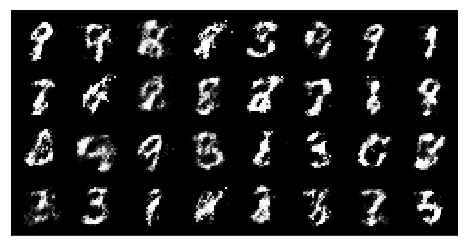

Epoch:13,   G_loss:2.3098676461400762,   D_loss:0.7714151078576981


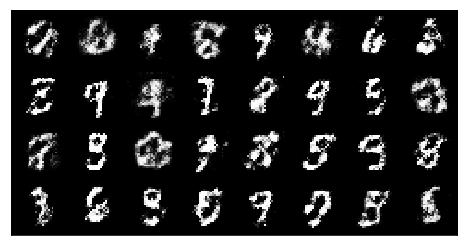

Epoch:14,   G_loss:2.0456431302180422,   D_loss:0.8214513115537192


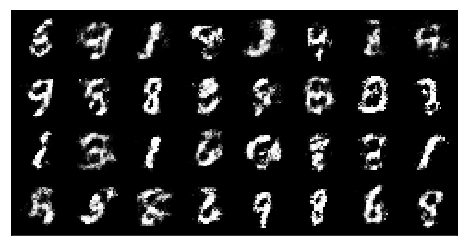

Epoch:15,   G_loss:1.8841786695950067,   D_loss:0.8420565196954365


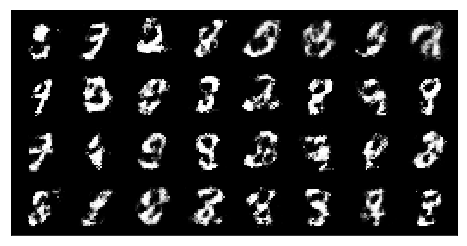

Epoch:16,   G_loss:1.832546234893392,   D_loss:0.8453632477504104


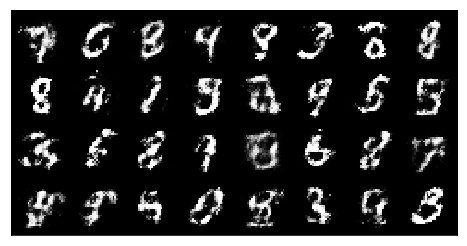

Epoch:17,   G_loss:1.8066995944549789,   D_loss:0.8542930172450507


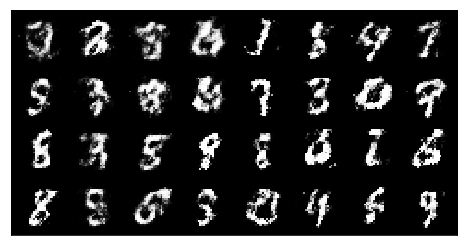

Epoch:18,   G_loss:1.8322350769154807,   D_loss:0.8233043290912978


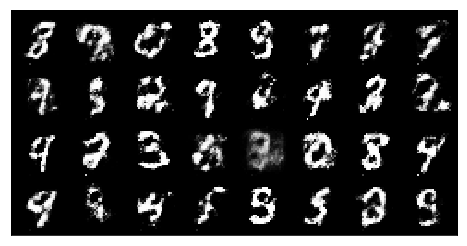

Epoch:19,   G_loss:1.8457369219773867,   D_loss:0.8215697022007981


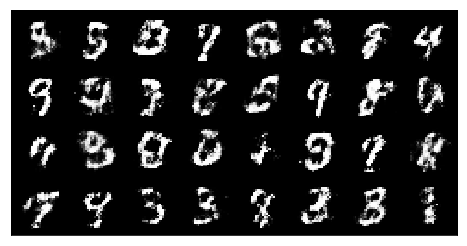

In [11]:
# training loop
for epoch in range(20):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i,data in enumerate(trainloader):
        X, _ = data
        X = X.view(X.size(0), -1)
        mb_size = X.size(0)
        
        # Definig labels for real (1s) and fake (0s) images
        one_labels = torch.ones(mb_size, 1)
        zero_labels = torch.zeros(mb_size, 1)
        
        # Random normal distribution for each image
        z = torch.randn(mb_size, Z_dim)
        
        # Feed forward in discriminator both 
        # fake and real images
        D_real = D(X)
        D_fake = D(G(z))
        
        # Defining the loss for Discriminator
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_fake_loss + D_real_loss
        
        # backward propagation for discriminator
        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()
        
        # Feed forward for generator
        z = torch.randn(mb_size, Z_dim)
        D_fake = D(G(z))
        
        # loss function of generator
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        # backward propagation for generator
        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()
        
        G_loss_run += G_loss.item()
        D_loss_run += D_loss.item()
        
    # printing loss after each epoch 
    print('Epoch:{},   G_loss:{},   D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1) ))
    
    # Plotting fake images generated by generator
    samples = G(z).detach()
    samples = samples.view(samples.size(0), 1, 28, 28)
    imshow(samples)